This notebook replicates the agent_motion_prediction notebook that Lyft publishes

In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../datasets'
dm = LocalDataManager(None)

cfg = load_config_data('./prediction_example.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'sample/meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'sample/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'sample/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
def build_model(cfg: Dict) -> torch.nn.Module:
    model = resnet50(pretrained=True)
    
    num_history_channels = (cfg['model_params']['history_num_frames'] + 1) * 2
    num_in_channels = 3 + num_history_channels
    
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False
    )
    
    num_targets = 2 * cfg['model_params']['future_num_frames']
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)
    
    return model

In [4]:
def forward(data, model, device, criterion):
    inputs = data['image'].to(device)
    target_availabilities = data['target_availabilities'].unsqueeze(-1).to(device)
    targets = data['target_positions'].to(device)
    
    # forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

In [5]:
# this is where we ideally use tda and such

In [6]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg['shuffle'], batch_size=train_cfg['batch_size'],
                              num_workers=train_cfg['num_workers'])

sample/meta.json is not present in local data folder ../../datasets
!!dataset metafile not found!! the hard-coded matrix will be loaded.
This will be deprecated in future releases


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')

In [8]:
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg['train_params']['max_num_steps']))
losses_train = []

for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses_train.append(loss.item())
    progress_bar.set_description(f'loss: {loss.item()} loss(avg): {np.mean(losses_train)}')

loss: 225.1035614013672 loss(avg): 127.28712196350098: 100%|██████████| 5/5 [00:35<00:00,  7.05s/it] 


In [9]:
num_frames_to_chop = 100
eval_cfg = cfg['val_data_loader']
eval_base_path = create_chopped_dataset(dm.require(eval_cfg['key']), cfg['raster_params']['filter_agents_threshold'],
                                        num_frames_to_chop, cfg['model_params']['future_num_frames'], MIN_FUTURE_STEPS)

extracting GT:   7%|▋         | 32/480 [00:00<00:01, 318.36it/s]

warning, you're running with a custom agents_mask


extracting GT: 100%|██████████| 480/480 [00:01<00:00, 315.72it/s]


In [10]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg['key'])).name)
eval_mask_path = str(Path(eval_base_path) / 'mask.npz')
eval_gt_path = str(Path(eval_base_path) / 'gt.csv')

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)['arr_0']

eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg['shuffle'], batch_size=eval_cfg['batch_size'],
                             num_workers=eval_cfg['num_workers'])

print(eval_dataset)

warning, you're running with a custom agents_mask
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [11]:
model.eval()
torch.set_grad_enabled(True)

future_coords_offsets_pd = []
timestamps = []

agents_ids = []
progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, outputs = forward(data, model, device, criterion)
    future_coords_offsets_pd.append(outputs.cpu().detach().numpy().copy())
    timestamps.append(data['timestamp'].numpy().copy())
    agents_ids.append(data['track_id'].numpy().copy())

100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


In [12]:
pred_path = f'{gettempdir()}/pred.cvs'

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agents_ids),
               coords=np.concatenate(future_coords_offsets_pd))

In [13]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)

neg_multi_log_likelihood 512862.24546288786
time_displace [ 20.27850688  18.38155824  14.64364658  16.58865914  51.15349317
  75.41053752  76.82622062  69.7310363   90.5423647  100.05446631
 111.06285021 103.9981038  142.09281895 163.98357409 146.49125658
 155.74472261 151.97341342 152.79893528 155.07448294 148.6360519
 180.06064898 168.69887139 159.88781796 126.28542326 129.1062965
 144.32622883 139.26410588 147.19051283 122.72923036 127.85821051
 147.84048697 133.14539131 139.00378829 147.31375133 144.82422824
 162.38568714 133.74459473 172.60258219 151.87030932 151.77224349
 152.0639287  149.69796814 143.334549   116.17609026 121.4288618
 138.49301987 134.14599032 199.8244749  197.98465941 173.70524256]


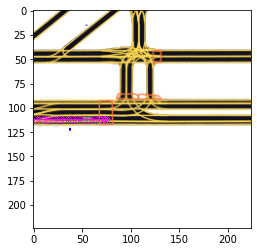

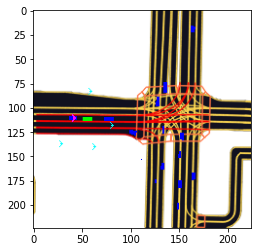

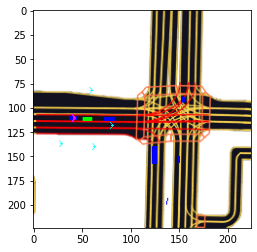

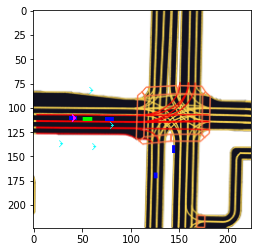

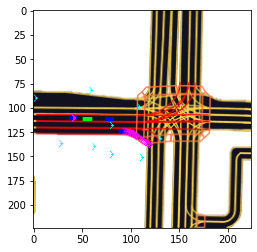

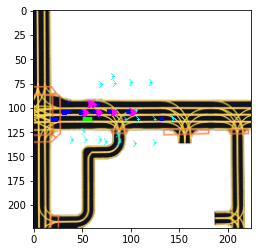

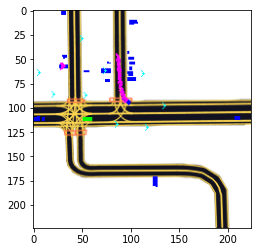

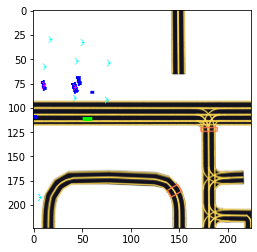

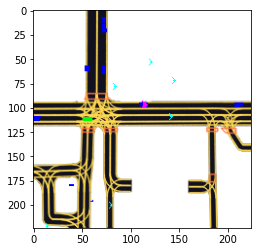

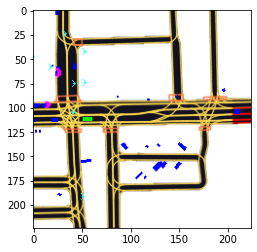

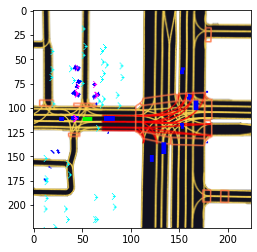

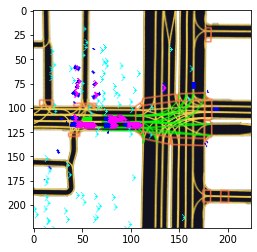

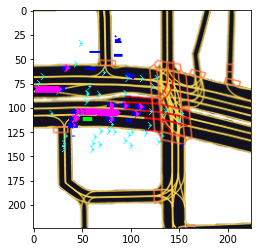

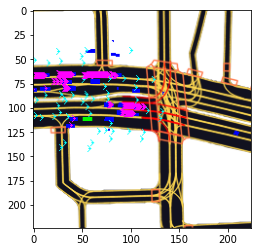

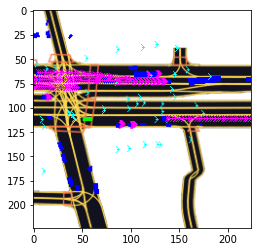

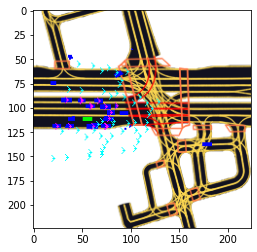

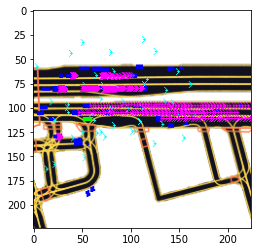

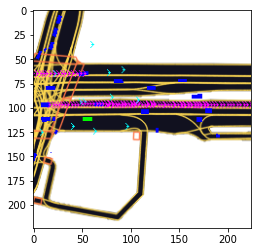

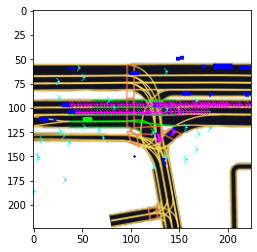

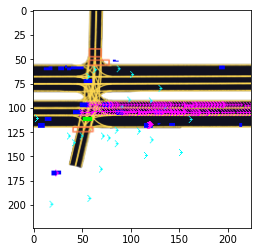

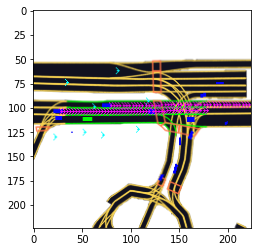

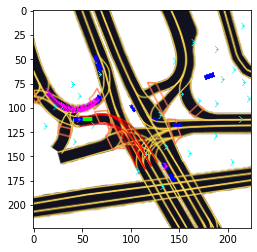

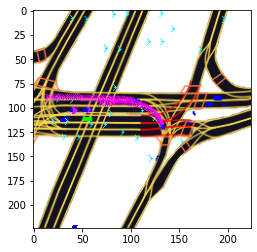

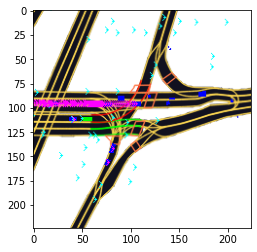

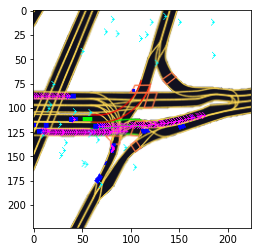

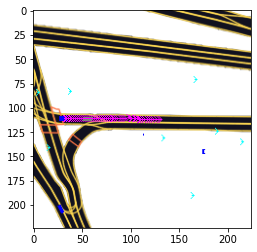

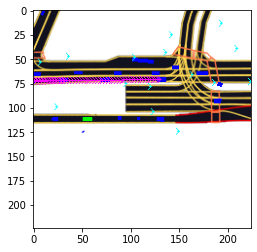

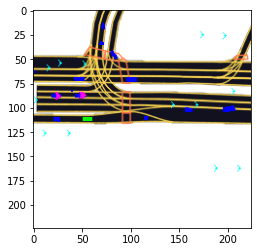

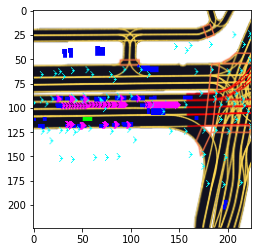

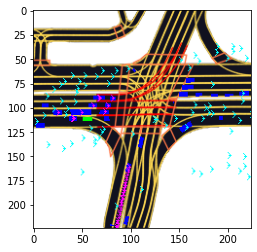

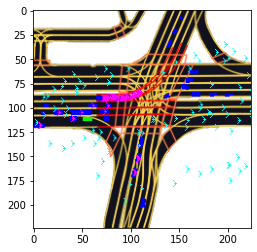

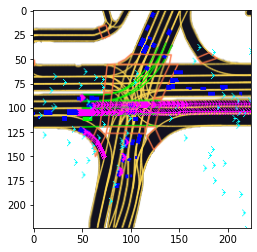

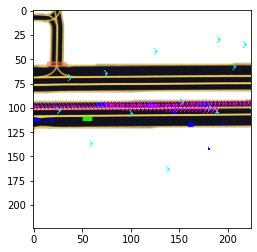

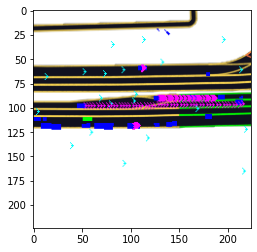

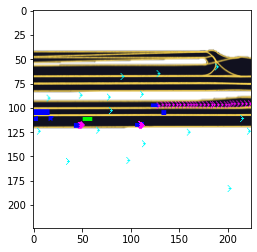

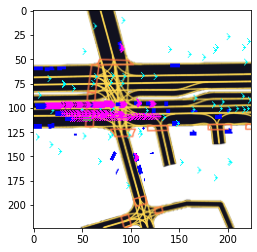

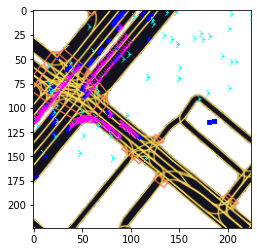

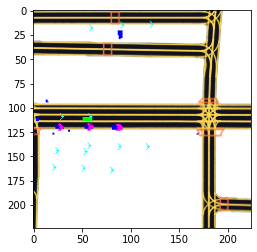

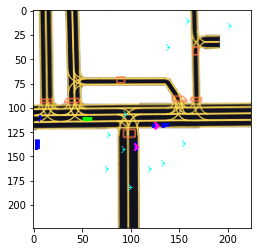

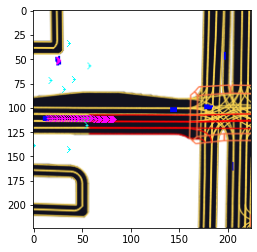

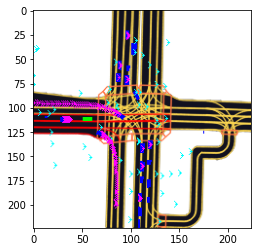

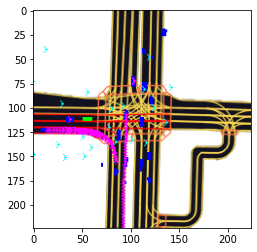

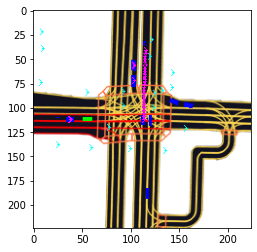

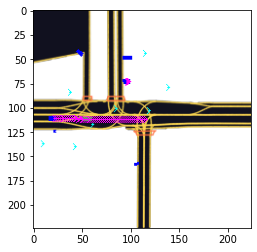

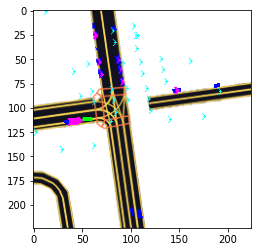

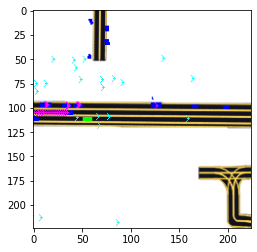

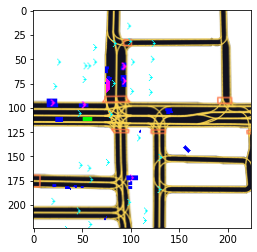

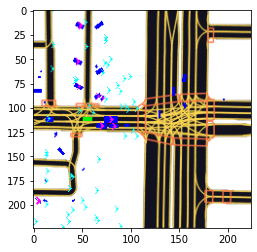

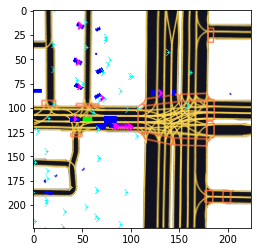

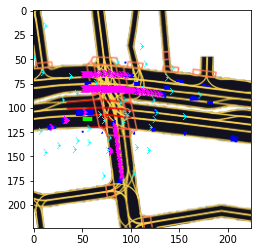

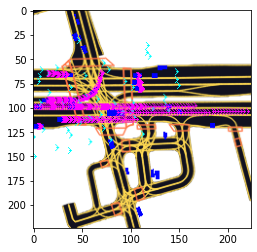

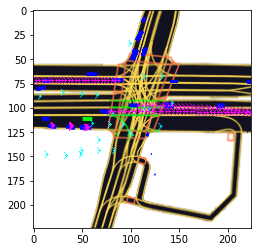

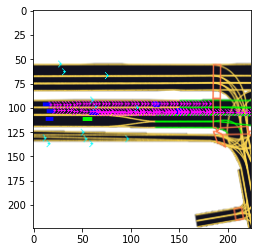

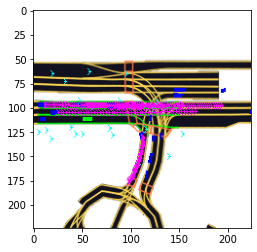

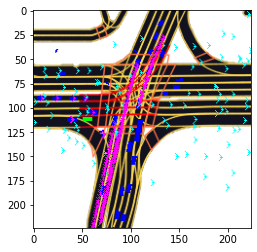

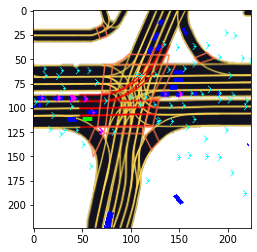

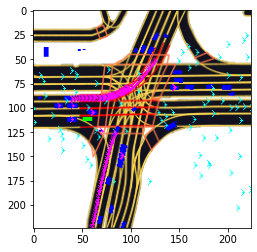

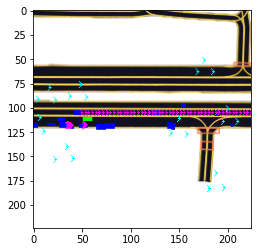

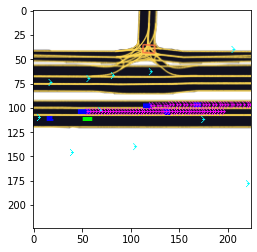

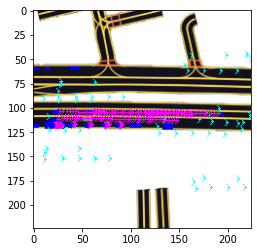

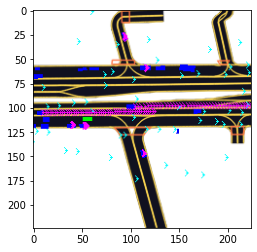

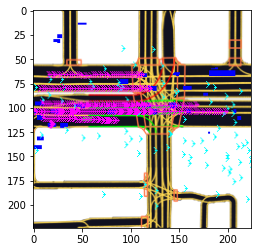

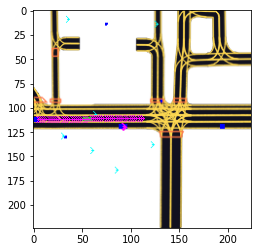

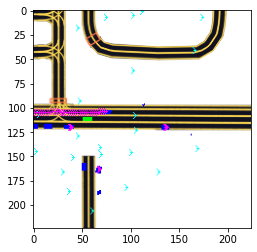

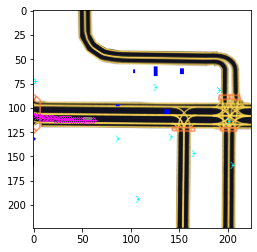

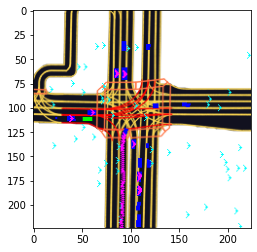

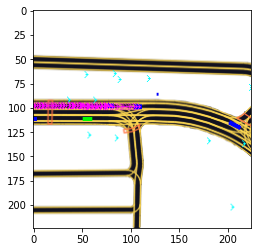

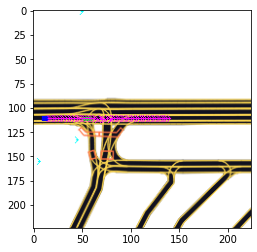

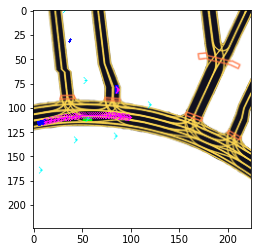

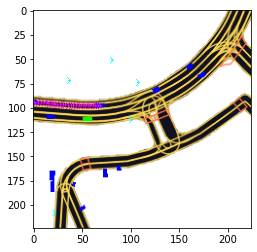

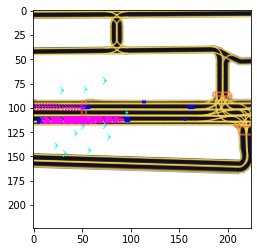

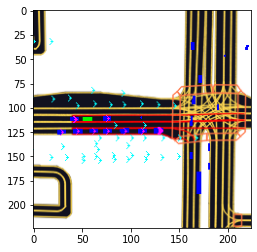

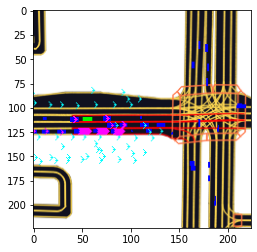

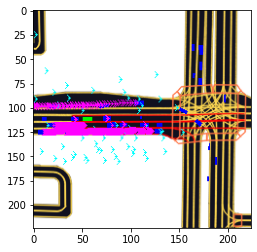

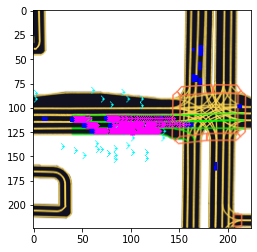

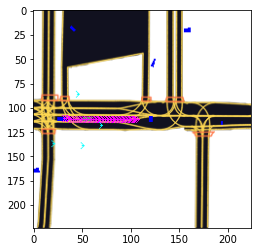

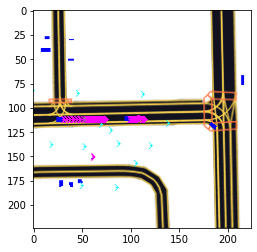

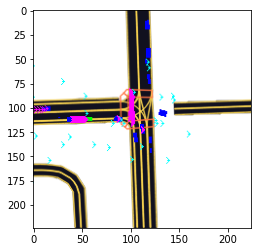

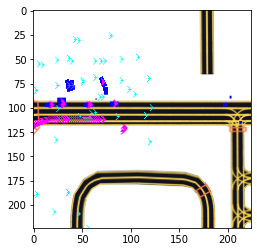

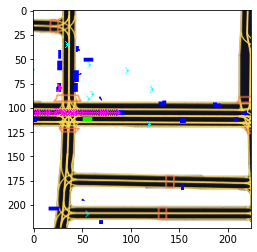

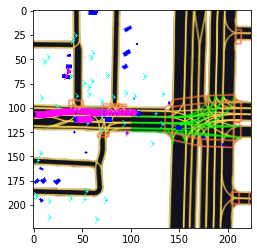

In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(out_pos + data_agent["centroid"][:2])
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["world_to_image"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["world_to_image"])

    yaws = np.zeros((len(predicted_positions), 1))
    draw_trajectory(im_ego, predicted_positions, yaws, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, yaws, TARGET_POINTS_COLOR)

    plt.imshow(im_ego[::-1])
    plt.show()